In [1]:
import tensorflow as tf
import tensorflow_federated as tff
import functools

2023-05-08 19:45:19.873808: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 19:45:22.425799: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps
import nilearn as nl
import nibabel as nib

# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard




np.set_printoptions(precision=3, suppress=True)

In [3]:
print(tff.federated_computation(lambda: 'Hello World')())

2023-05-08 19:46:38.712493: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-08 19:46:38.712782: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-05-08 19:46:38.713075: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-08 19:46:38.714718: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-08 19:46:38.789840: I tensorflow/compiler/xla/stream_executor/

b'Hello World'


In [4]:
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
  
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss


def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [5]:
def create_tff_model():
    return tff.learning.from_keras_model(
        keras_model=model1,  # use any of the models as a template
        input_spec=None,  # provide input_spec if needed
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing])

In [6]:
def get_weights(model):
    return [v.numpy() for v in model.trainable_variables]

In [7]:
# Load the models
model1 = keras.models.load_model('/home/ioj24/Desktop/Multimodal Image Segmentation/code/u-net_part1.h5', 
                                custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                "dice_coef": dice_coef,
                                                "precision": precision,
                                                "sensitivity":sensitivity,
                                                "specificity":specificity,
                                                "dice_coef_necrotic": dice_coef_necrotic,
                                                "dice_coef_edema": dice_coef_edema,
                                                "dice_coef_enhancing": dice_coef_enhancing
                                               }, compile=False)

model2 = keras.models.load_model('/home/ioj24/Desktop/Multimodal Image Segmentation/code/u-net_part2.h5', 
                                custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                "dice_coef": dice_coef,
                                                "precision": precision,
                                                "sensitivity":sensitivity,
                                                "specificity":specificity,
                                                "dice_coef_necrotic": dice_coef_necrotic,
                                                "dice_coef_edema": dice_coef_edema,
                                                "dice_coef_enhancing": dice_coef_enhancing
                                               }, compile=False)

model3 = keras.models.load_model('/home/ioj24/Desktop/Multimodal Image Segmentation/code/u-net_part3.h5', 
                                custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                "dice_coef": dice_coef,
                                                "precision": precision,
                                                "sensitivity":sensitivity,
                                                "specificity":specificity,
                                                "dice_coef_necrotic": dice_coef_necrotic,
                                                "dice_coef_edema": dice_coef_edema,
                                                "dice_coef_enhancing": dice_coef_enhancing
                                               }, compile=False)

# Load the training histories
history1 = pd.read_csv('/home/ioj24/Desktop/Multimodal Image Segmentation/code/egitim_part1.log', sep=',', engine='python')
history2 = pd.read_csv('/home/ioj24/Desktop/Multimodal Image Segmentation/code/egitim_part2.log', sep=',', engine='python')
history3 = pd.read_csv('/home/ioj24/Desktop/Multimodal Image Segmentation/code/egitim_part3.log', sep=',', engine='python')

2023-05-08 19:46:49.905889: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-08 19:46:49.906359: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-08 19:46:49.906644: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [8]:
weights1 = get_weights(model1)
weights2 = get_weights(model2)
weights3 = get_weights(model3)


In [9]:
average_weights = [(w1 + w2 + w3) / 3.0 for w1, w2, w3 in zip(weights1, weights2, weights3)]


In [10]:
global_model = keras.models.clone_model(model1)
global_model.build(model1.input_shape)
global_model.set_weights(average_weights)

global_model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )


In [11]:
global_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   608         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 32)   0           ['conv2d_1[0][0]']               
                                                                                              

In [20]:
global_model.save("u-net_global_untrain.h5")

Load The Dataset and ReTrain The Global Model

In [12]:
"""
Label definition and required parameters
"""
SEGMENT_CLASSES = {
0 : 'No Tumor',
1 : 'Necrotic/Nuclear', #Tumor Nucleus
2 : 'Edema',#Edema Part
3 : 'Expanding Tumor' #Expanding Tumor Part
}

IMG_SIZE=64


VOLUME_SLICES = 100
VOLUME_START_AT = 22 

# Verilerin ön incelenmesi ve görselleştirilmesi
TRAIN_DATASET_PATH = '/home/ioj24/Desktop/Multimodal Image Segmentation/Datasets/BraTS2020_TrainingData/part1_training'
VALIDATION_DATASET_PATH = '/home/ioj24/Desktop/Multimodal Image Segmentation/Datasets/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'


In [13]:
import os
os.listdir(TRAIN_DATASET_PATH)
os.listdir(VALIDATION_DATASET_PATH)

['BraTS20_Validation_010',
 'BraTS20_Validation_121',
 'BraTS20_Validation_105',
 'BraTS20_Validation_097',
 'BraTS20_Validation_100',
 'BraTS20_Validation_019',
 'BraTS20_Validation_008',
 'BraTS20_Validation_022',
 'BraTS20_Validation_112',
 'BraTS20_Validation_088',
 'BraTS20_Validation_036',
 'BraTS20_Validation_061',
 'BraTS20_Validation_007',
 'BraTS20_Validation_040',
 'BraTS20_Validation_079',
 'BraTS20_Validation_065',
 'BraTS20_Validation_066',
 'BraTS20_Validation_115',
 'BraTS20_Validation_110',
 'BraTS20_Validation_090',
 'BraTS20_Validation_084',
 'BraTS20_Validation_018',
 'BraTS20_Validation_124',
 'BraTS20_Validation_032',
 'BraTS20_Validation_120',
 'BraTS20_Validation_074',
 'BraTS20_Validation_029',
 'BraTS20_Validation_012',
 'BraTS20_Validation_101',
 'BraTS20_Validation_005',
 'BraTS20_Validation_116',
 'BraTS20_Validation_067',
 'BraTS20_Validation_070',
 'BraTS20_Validation_081',
 'BraTS20_Validation_086',
 'BraTS20_Validation_089',
 'BraTS20_Validation_049',
 

In [14]:
print(len(os.listdir(TRAIN_DATASET_PATH)))
print(len(os.listdir(VALIDATION_DATASET_PATH)))

123
127


In [15]:
""" Verilerin yüklenmesi"""

train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
        
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories)


train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [16]:
""" (İsteğe bağlı data generator) Verilerimizin boyutu çok büyük olduğundan dolayı biz bu verilerin hepsini Ram'e almak istemedik. Altarnatif çözüm olarak 
Stanford Üniversitesinin 2 Hocası tarafından geliştirilen Data Generatörü projemize dahil ettik."""


class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))


        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii')
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii')
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii')
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT]

        # Generate masks
        y[y==4] = 3
        mask = tf.one_hot(y, 4)
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        return X/np.max(X), Y

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

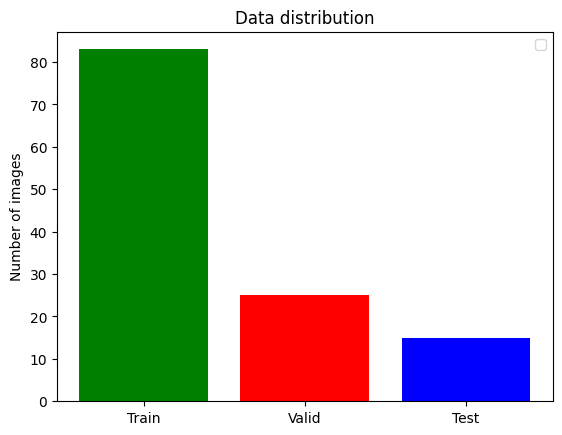

In [17]:
"""Veri setimizin dağılım grafiği"""

def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()

showDataLayout()

In [18]:
""" modelin eğitim sırasında oluşan tüm değerleri tutar ve kaydeder.        egitim.log"""

csv_logger = CSVLogger('egitim_global.log', separator=',', append=False)

"""
During the training of the model, the code snippet creates two callbacks.

The first callback, CSVLogger, logs and saves all the values that are generated during the training process to a CSV file named 'egitim.log'. This can be used to analyze the training process later.

The second callback, ReduceLROnPlateau, modifies the learning rate of the model by a factor of 0.2 if there is no improvement in the validation loss for two consecutive epochs. This can speed up the learning process during training by changing the weight states related to the learning rate by 2 to 10 times faster than the normal training. This callback is called at the end of every epoch, and it tracks the validation loss as a parameter.

Both callbacks are passed to the fit method of the Keras model during training.
"""

callbacks = [
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),

        csv_logger
    ]

In [19]:
#model fit
K.clear_session()

history =  global_model.fit(training_generator,
                     epochs=20,
                     steps_per_epoch=len(train_ids),
                     callbacks= callbacks,
                     validation_data = valid_generator
                     )
global_model.save("u-net_global.h5")

Epoch 1/20


2023-05-08 19:47:10.869529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-08 19:47:16.015038: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-08 19:47:18.488010: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-08 19:47:23.085383: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f5a8c00d5e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-08 19:47:23.085442: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device 

83/83 [==============================] - ETA: 0s - loss: 0.1126 - accuracy: 0.9871 - mean_io_u_3: 0.4451 - dice_coef: 0.2691 - precision: 0.9640 - sensitivity: 0.9570 - specificity: 0.9961 - dice_coef_necrotic: 0.0576 - dice_coef_edema: 0.1117 - dice_coef_enhancing: 0.0680

2023-05-08 19:48:41.500742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


83/83 [==============================] - 100s 884ms/step - loss: 0.1126 - accuracy: 0.9871 - mean_io_u_3: 0.4451 - dice_coef: 0.2691 - precision: 0.9640 - sensitivity: 0.9570 - specificity: 0.9961 - dice_coef_necrotic: 0.0576 - dice_coef_edema: 0.1117 - dice_coef_enhancing: 0.0680 - val_loss: 0.0447 - val_accuracy: 0.9869 - val_mean_io_u_3: 0.6354 - val_dice_coef: 0.3156 - val_precision: 0.9891 - val_sensitivity: 0.9851 - val_specificity: 0.9964 - val_dice_coef_necrotic: 0.1368 - val_dice_coef_edema: 0.1861 - val_dice_coef_enhancing: 0.1486 - lr: 0.0010
Epoch 2/20
83/83 [==============================] - 72s 865ms/step - loss: 0.0573 - accuracy: 0.9871 - mean_io_u_3: 0.5154 - dice_coef: 0.2877 - precision: 0.9877 - sensitivity: 0.9856 - specificity: 0.9959 - dice_coef_necrotic: 0.0883 - dice_coef_edema: 0.1579 - dice_coef_enhancing: 0.0971 - val_loss: 0.0425 - val_accuracy: 0.9869 - val_mean_io_u_3: 0.5168 - val_dice_coef: 0.3130 - val_precision: 0.9887 - val_sensitivity: 0.9857 - val_

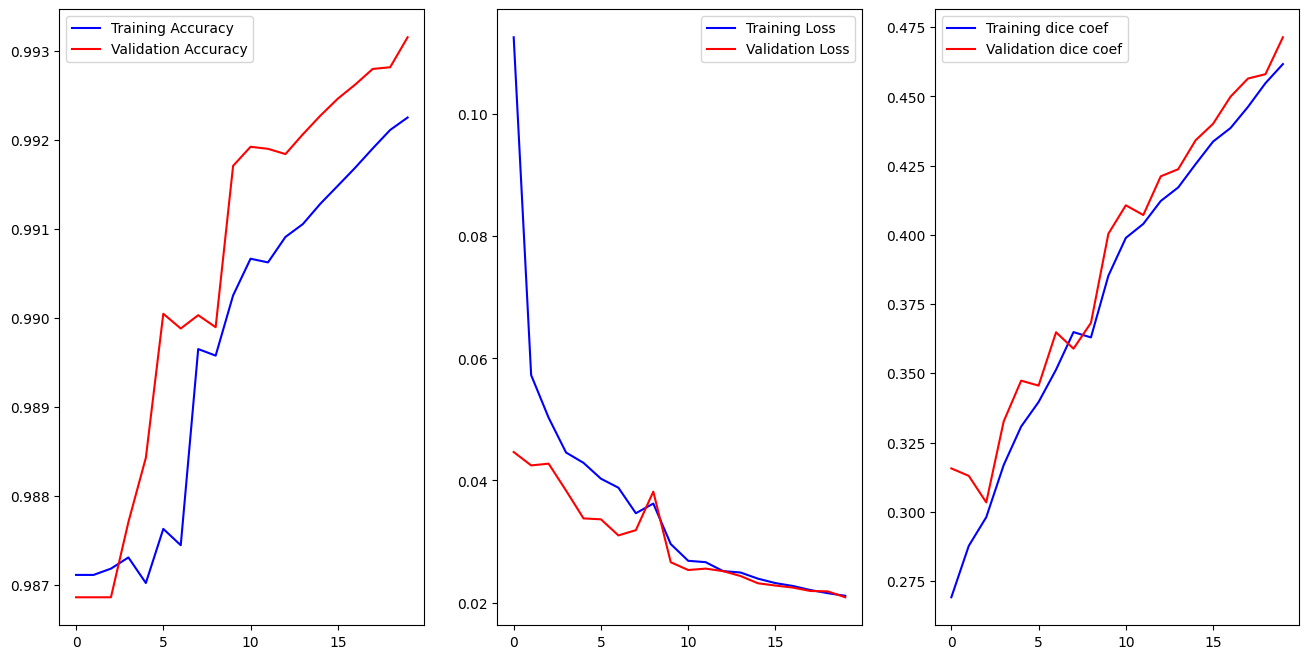

In [21]:
#Modelin yüklenmesi
#Modelin tahmin aşamasında kullanması için eğitim sonrası değerleri tekrar yükledik.
model = keras.models.load_model('u-net_global.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

#Eğitim sonrası bize grafikleri verdi 
history = pd.read_csv('egitim_global.log', sep=',', engine='python')

hist=history



acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,3,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()


plt.show()